<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square-Project/blob/master/Pratice/REDNet_Pratice(wikibook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/wikibook/tf2/blob/master/Chapter9.ipynb

이 코드의 내용은 wikibook을 참고했음을 밝힙니다.

# Oxford Pet Dataset 불러오기

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU, Add, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np

tf.executing_eagerly()

Using TensorFlow backend.


True

In [3]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.1.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteJAJJPP/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteJAJJPP/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


# Dataset 정보 확인

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

# train, test 데이터 수 저장

In [0]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

# 이미지 로드 함수 정의

In [0]:
def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1

    return img, mask

# train, test Dataset 정의

In [0]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

# 이미지, 마스크 확인

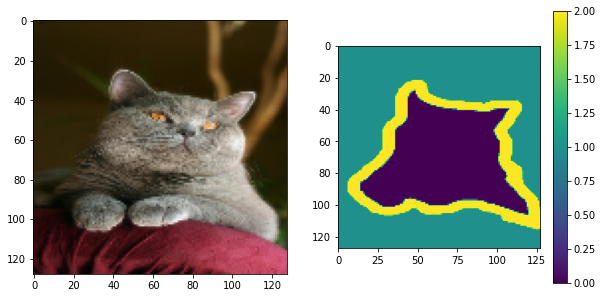

In [8]:
import matplotlib.pyplot as plt
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img[2])
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask[2], axis=2))
    plt.colorbar()

# Segmentation을 위한 REDNet 네트워크 정의

https://arxiv.org/abs/1806.01054

In [0]:
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = Input(shape=(None, None, 3))
    conv_layers.append(Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i%2==0:
            residual_layers.append(x)

    for i in range(num_layers-1):
        if i%2==1:
            x = Add()([x, residual_layers.pop()])
            x = Activation('relu')(x)
        x = deconv_layers[i](x)

    x = deconv_layers[-1](x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

# Segmentation을 위한 REDNet 네트워크 초기화 및 컴파일

In [0]:
model = REDNet_segmentation(15)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 3 84          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, None, 6 1792        conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, None, 6 36928       conv2d_18[0][0]                  
______________________________________________________________________________________________

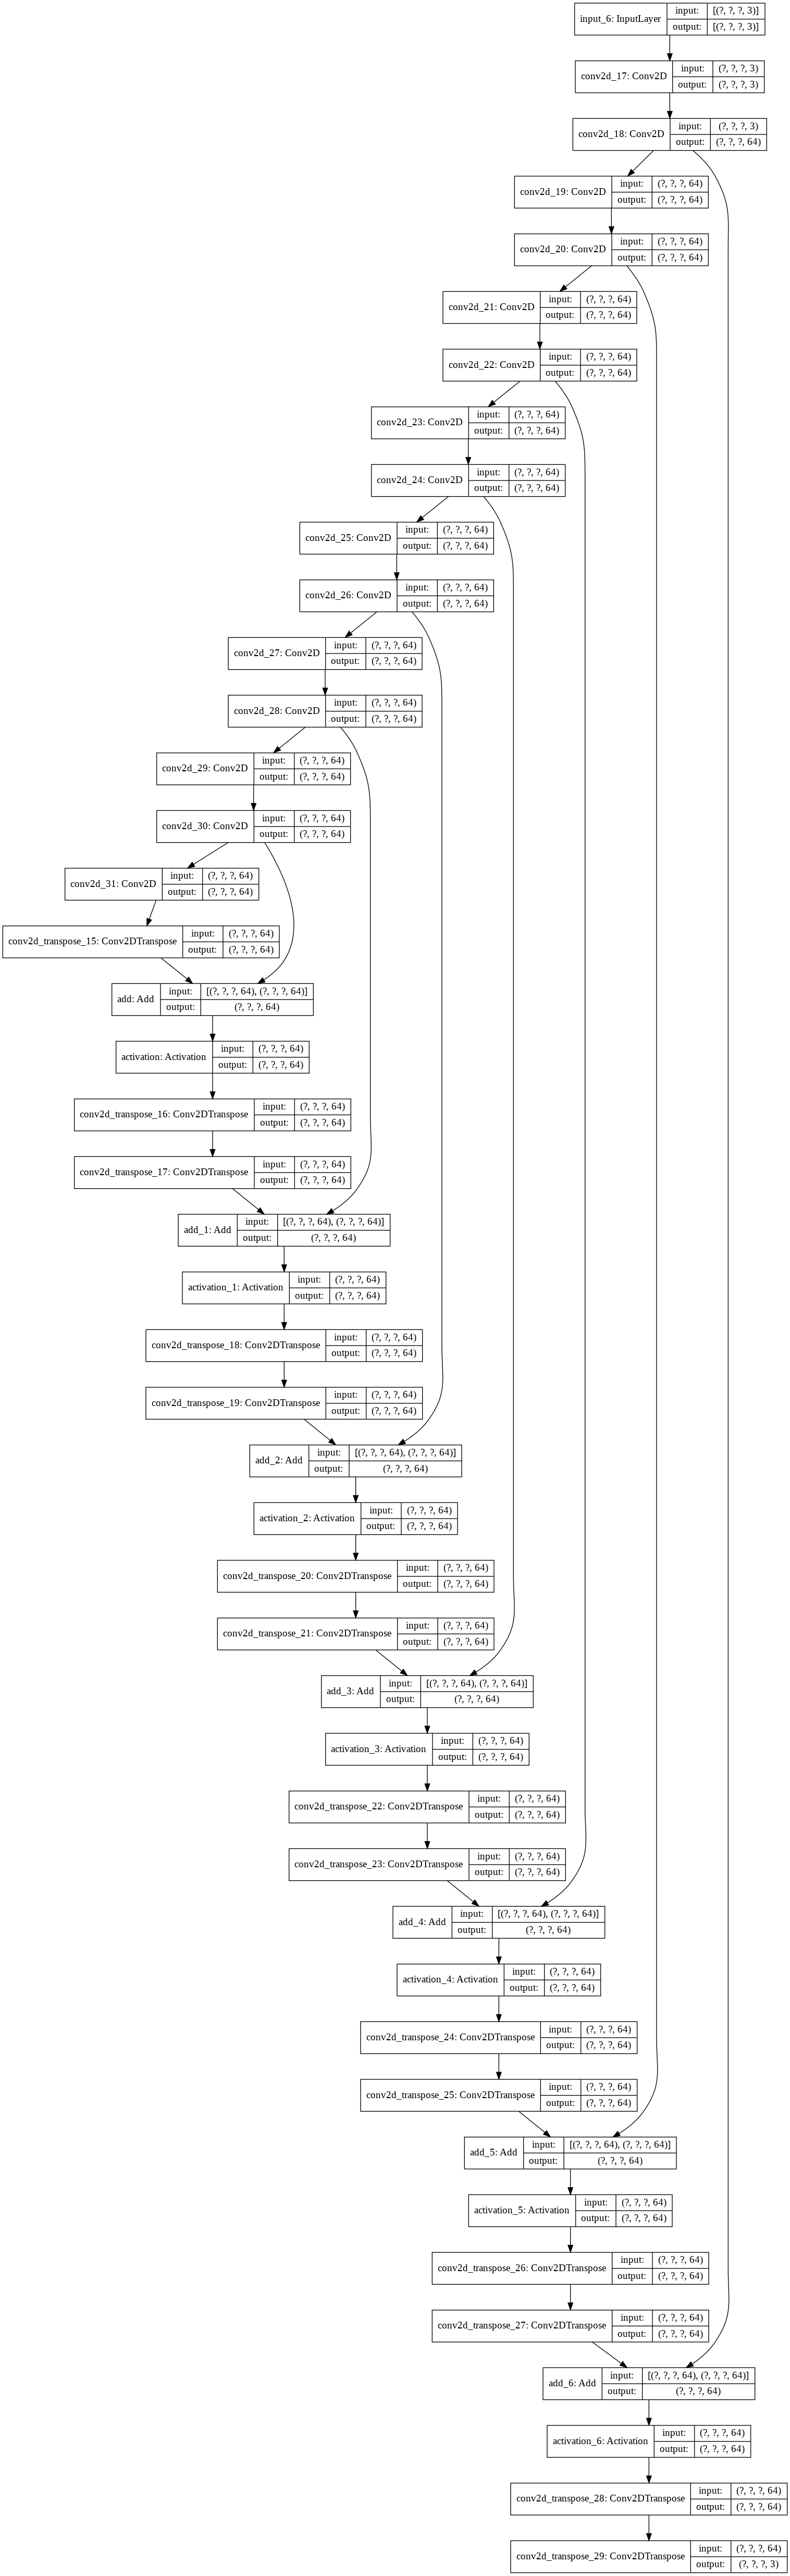

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Segmentation을 위한 REDNet 네트워크 학습

In [22]:
history = model.fit(train_dataset,
                    epochs=20,
                    steps_per_epoch=train_data_len//16,
                    validation_data=test_dataset,
                    validation_steps=test_data_len)

Train for 230 steps, validate for 3669 steps
Epoch 1/20
230/230 [==============================] - 94s 408ms/step - loss: 0.8577 - accuracy: 0.5922 - val_loss: 0.7890 - val_accuracy: 0.6355
Epoch 2/20
230/230 [==============================] - 85s 370ms/step - loss: 0.7606 - accuracy: 0.6508 - val_loss: 0.7743 - val_accuracy: 0.6473
Epoch 3/20
230/230 [==============================] - 87s 376ms/step - loss: 0.7325 - accuracy: 0.6720 - val_loss: 0.7203 - val_accuracy: 0.6864
Epoch 4/20
230/230 [==============================] - 84s 367ms/step - loss: 0.6814 - accuracy: 0.6977 - val_loss: 0.7110 - val_accuracy: 0.6819
Epoch 5/20
230/230 [==============================] - 84s 367ms/step - loss: 0.6561 - accuracy: 0.7123 - val_loss: 0.6777 - val_accuracy: 0.7054
Epoch 6/20
230/230 [==============================] - 86s 374ms/step - loss: 0.6404 - accuracy: 0.7207 - val_loss: 0.6746 - val_accuracy: 0.7063
Epoch 7/20
230/230 [==============================] - 85s 370ms/step - loss: 0.6279 -

# 테스트 이미지 분할 확인

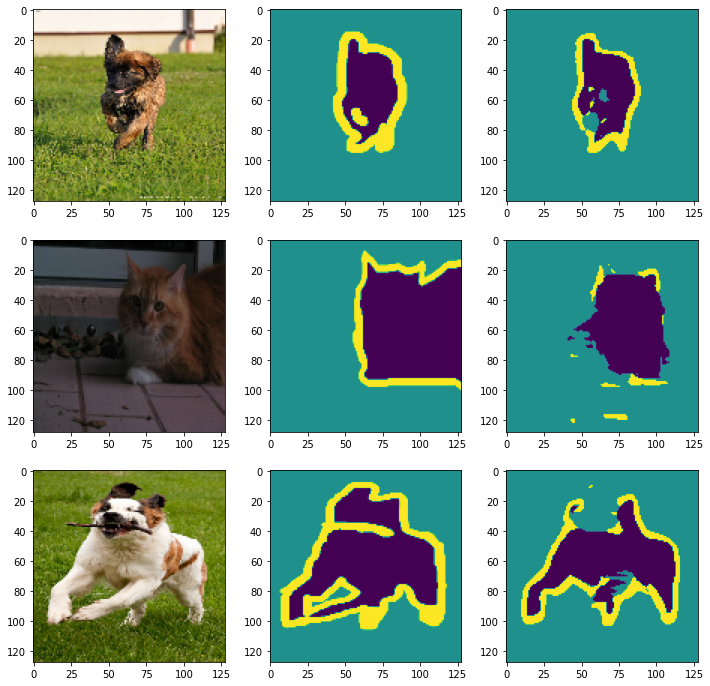

In [29]:
plt.figure(figsize=(12, 12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):    # test_dataset: 이미지 로드 함수를 적용한 데이터셋
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))
    
    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(predict[0])  # plt.imshow(np.squeeze(predict, axis=0))

# 테스트 이미지 분할 확인(원본)

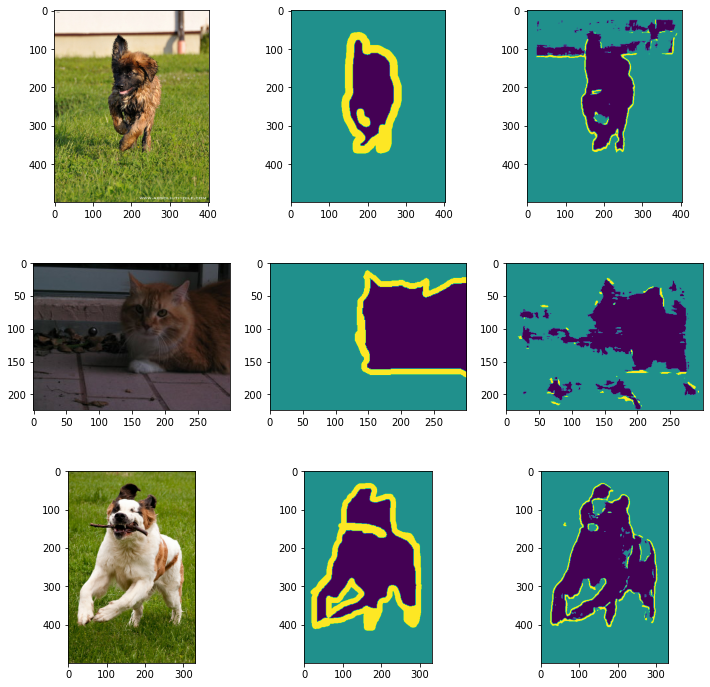

In [31]:
plt.figure(figsize=(12, 12))
for idx, datapoint in enumerate(dataset['test'].take(3)):   # dataset['test']: 이미지 로드 함수를 적용하지 않은 데이터셋
    img = datapoint['image']
    mask = datapoint['segmentation_mask']

    img = tf.cast(img, tf.float32)  # keras.backend.cast(img, 'float32')
    img = img / 255.0
    mask -= 1

    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img)

    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask, axis=2))

    predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)    # np.expand_dims(img, axis=0)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(predict[0])  # plt.imshow(np.squeeze(predict, axis=0))

# Note

### python map

https://dojang.io/mod/page/view.php?id=2286

map은 리스트의 요소를 지정된 함수로 처리해주는 함수입니다(map은 원본 리스트를 변경하지 않고 새 리스트를 생성합니다).<br><br>

* list(map(함수, 리스트))
* tuple(map(함수, 튜플))

In [0]:
# 실수가 저장된 리스트의 모든 요소를 정수로 변환
a = [1.2, 2.5, 3.7, 4.6]

# for문
for i in range(len(a)):
    a[i] = int(a[i])


# map
a = list(map(int, a))

In [0]:
# 객체

a = list(map(str, range(10)))
print(a)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [0]:
# input().split()

a = input().split()
print(a)

10 20
['10', '20']


In [0]:
# map

a = map(int, input().split())
print(a)
print(list(a))

10 20
[10, 20]


### reshape, squeeze, expand_dims

https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221164750517&proxyReferer=https%3A%2F%2Fwww.google.com%2F

* reshape
원하는 shape을 직접 입력하여 바꿀 수 있다. 특히 shape에 -1을 입력하면 고정된 차원은 우선 채우고 남은 부분을 알아서 채워준다.

* squeeze
차원 중 사이즈가 1인 것을 찾아 스칼라값으로 바꿔 해당 차원을 제거한다.

* exapnd_dims
axis로 지정된 차원을 추가한다.

In [0]:
arr = np.array([[1], [2], [3]])

expansion = np.expand_dims(arr, axis=0)
reduction = np.squeeze(arr, axis=1)

print(arr, arr.shape, end='\n\n')
print(expansion, expansion.shape, end='\n\n')
print(reduction, reduction.shape)

[[1]
 [2]
 [3]] (3, 1)

[[[1]
  [2]
  [3]]] (1, 3, 1)

[1 2 3] (3,)


In [0]:
arr = np.array([
    [
        [1, 2],
        [3, 4]
    ],
    [
        [5, 6],
        [7, 8]
    ]
])

expand_dims = np.reshape(arr, (1, 1, 2, 4))
reduction = np.reshape(arr, (4, -1))

print(arr, arr.shape, end='\n\n')
print(expand_dims, expand_dims.shape, end='\n\n')
print(reduction, reduction.shape)

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]] (2, 2, 2)

[[[[1 2 3 4]
   [5 6 7 8]]]] (1, 1, 2, 4)

[[1 2]
 [3 4]
 [5 6]
 [7 8]] (4, 2)
